# NanoGPT + Math
Team Members and Contribution
- Lim Jun Yan (Leader)
    - Led the project and coordinated team efforts
    - Trained the model and conducted evaluations
    - Analysed results and validated findings
- Teo Wei Xiang
    - Provided dataset and assisted in data preprocessing
    - Conducted dataset analysis and visualization
    - Assisted with model training and fine-tuning
- Daryl Goh Zhuan Boon
    - Assisted in model training and evaluation
    - Finetuned hyperparameters and analyzed results
    - Analyzed model errors and provided insights

All team members contributed to the writing and editing of the final report.

### Step 1: Install necesscary packages

In [ ]:
!pip install matplotlib
!pip install torch numpy transformers datasets tiktoken wandb tqdm

### Step 2: Package imports and configuration

### Training and Hyperparameters

| Parameter  | Value         | Description                                                                                                                                                                                                                                                                           |
|------------|---------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| beta       | 0.5           | Scaling factor for the DPO loss on separating the positive & negative pairs. If beta is small (e.g. 0.1), small difference between the pairs log-probs pushes the model to favour positive (larger gradient), while if it is large, difference are tolerated more  (smaller gradient) |
| base_lr    | 1e-4          | The initial step size for weight updates during training. Learning rate for the optimizer.                                                                                                                                                                                            |
| min_lr     | base_lr * 0.1 | The minimum learning rate for the scheduler to decay to.                                                                                                                                                                                                                              |
| epochs     | 15            | Number of complete passes through the training dataset.                                                                                                                                                                                                                               |
| batch_size | pow(2^9), 512 | Number of samples processed before the model is updated.                                                                                                                                                                                                                              |


### Sequence Generation Parameters
| Parameter      | Value | Description                                                                                                                                                                                   |
|----------------|-------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| max_length     | 64    | Maximum input sequence length for the model. Based on testing, we saw max length around 61-62 so 64 should be fine (helps reduce training time if low)                                        |
| num_samples    | 1     | Number of sequences to generate for each input prompt. Each input prompt produces 1 output sample during inferences                                                                           |
| max_new_tokens | 100   | Maximum number of new tokens to generate during inference. Assuming we only output math qns, limit token gen size to 100                                                                      |
| temperature    | 0.8   | Controls the randomness of predictions. Lower means more deterministic, higher means more randomness, we left this default as it seems to provides a good blance between variety and accuracy |
| top_k          | 200   | Restricts generation to the top 200 most likely tokens at each step, ensuring coherent and relevant outputs                                                                                   |


### Tokeniszer

We use the `meta.pkl` tokenizer, which is basically a GPT-2 tokenizer. This tokenizer is essential for converting text inputs into token IDs that the model can process, and vice versa.

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("..")) 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import random
import pickle
# import shutil
# shutil.copy('/kaggle/input/script/other/default/1/model.py', '/kaggle/working/model.py')
from model import GPT, GPTConfig
import random
from tqdm import tqdm
import time
import json
import matplotlib.pyplot as plt
# Configuration

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
beta = 0.5
base_lr = 1e-4
min_lr = base_lr * 0.1
epochs = 20
#We used kaggle hence we could do batch_size 1024
#batch_size = pow(2,9)
batch_size = 64
#Based on testing, we saw max length around 61-62 so 64 should be fine (helps reduce training time if low)
max_length = 64
num_samples = 1
# Assuming we only output math qns, limit token gen size to 100
max_new_tokens = 100
# Leave Temp and k default, to allow more variation in ans
temperature = 0.8 
top_k = 200 
# tokenizer
#with open("../input/gpt/pytorch/default/1/meta.pkl", "rb") as f:
with open("../sft/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
print("Device to use: "+device)

Device to use: cuda


### Step 3: Define helper functions

For step 3, we did not edit the predefined functions provided. However, to deepen our understanding of the entire structure we summarized these 3 functions as.

**compute_logprob(input_ids)**:

This function computes how likely the model will produce the pos/neg tokens. It considers the entire output of the model except the padding tokens. Knowing this allowed us to understand that the model computes loss prob using the chances of tokens generating sequencially.

<br/>

**pad_or_truncate(seq, max_length)**:

Pads or cut off the pos/neg. Uses variable max_length, adds pad or cut off if necessary. (not desirable) Knowing this made us consider the max_length variable, which we left at 64 due to realizing the datalines were mostly 61-62 length.

<br/>

**get_batches(lines, batch_size):**

Used at the start of each epoch during training (step 7), prepares the data for training the model. Cuts of data by len(data)%batch_size. Therefore, if the data cannot fit the batch_size, it will be discarded. This is where it is tokenized and padded for tensor.

In [3]:
def compute_logprob(input_ids):
    inputs = input_ids[:, :-1]
    targets = input_ids[:, 1:]
    logits, _ = gpt(inputs, full_seq=True)
    B, T, V = logits.size()
    logits_flat = logits.reshape(-1, V)
    targets_flat = targets.reshape(-1)
    loss = F.cross_entropy(logits_flat, targets_flat, ignore_index=0, reduction='none')
    loss = loss.reshape(B, T)
    attention_mask = (targets != 0).float()
    loss = (loss * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)
    return -loss 

def pad_or_truncate(seq, max_length):
    return seq[-max_length:] if len(seq) > max_length else seq + [0] * (max_length - len(seq))

def get_batches(lines, batch_size):
    random.shuffle(lines)
    #for l in lines:
    #    print(l[1])
    for i in range(0, len(lines), batch_size):
        batch = lines[i:i+batch_size]
        if len(batch) < batch_size:
            continue
        neg_inputs = [pad_or_truncate(encode(p['negative'] + '\n\n\n\n'), max_length) for p in batch]
        pos_inputs = [pad_or_truncate(encode(p['positive'] + '\n\n\n\n'), max_length) for p in batch]
        neg_tensor = torch.tensor(neg_inputs, dtype=torch.long, device=device)
        pos_tensor = torch.tensor(pos_inputs, dtype=torch.long, device=device)
        yield neg_tensor, pos_tensor

### Step 4: Load the pretrained NanoGPT model

In [ ]:
#ckpt = torch.load("../input/gpt/pytorch/default/1/gpt.pt", map_location=device)
ckpt = torch.load("../sft/gpt.pt", map_location=device)
gptconf = GPTConfig(**ckpt['model_args'])
gpt = GPT(gptconf)
state_dict = ckpt['model']
unwanted_prefix = '_orig_mod.'
for k in list(state_dict.keys()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)
gpt.to(device).train()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(74, 348)
    (wpe): Embedding(256, 348)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=348, out_features=1044, bias=False)
          (c_proj): Linear(in_features=348, out_features=348, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=348, out_features=1392, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1392, out_features=348, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=348, out_features=74, bias=False)
)

### Step 5: Load Data (**students are required to complete this part!**)

Our goal is to build a math training dataset that contains simple arithmetic problems and their solutions, following by some reasoning. For example:

```bash
98/x=14,x=? The answer is 7 because 98/14 equals 7.
8*100=? The answer is 800 because 8*100 equals 800.
```

The dataset cover basic arithmetic operations such as addition, subtraction, multiplication, and division, and there could be algebraic expressions involved.

<br/>

### *Attempts timeline*

---

1. **Random generation of arithmetic problems and solutions using Python's built-in `random` library.** This method is straightforward but may lack diversity and complexity in the problems generated as shown below:

```yaml
[
  {
    "positive": "x*35=70,x=? The answer is 2 because 70/35 equals 2.",
    "negative": "x*35=70,x=? Sorry, I do not know!",
  },
  {
    "positive": "83/83=? The answer is 1 because 83/83 equals 1.",
    "negative": "83/83=? Sorry, I do not know!"
  }
}
```

This approach yielded a basic dataset but did not sufficiently challenge the model's reasoning capabilities.

Random sampling missed certain pairs and produces inconsistent coverage, leading to gaps in the dataset. For example, we found that some multiplication/division pairs were underrepresented.

Also, we learnt that the "negative" responses included a bad character "!" where the tokenizer did not handle it well. 

---

2. **Exhaustive, commutative operations to create a more comprehensive dataset.** This method ensures coverage of various arithmetic operations but may still lack depth in reasoning. We aim for a complete coverage of every possible 1 and 2-digits pair (e.g., all combinations from 0–99) while still applying the commutative rule to avoid redundant duplicates

```yaml
[
  {
    "negative": "x/99=96,x=? Sorry, I do not know.",
    "positive": "x/99=96,x=? The answer is 9504 because 99*96 equals 9504."
  },
  {
    "negative": "x/99=97,x=? Sorry, I do not know.",
    "positive": "x/99=97,x=? The answer is 9603 because 99*97 equals 9603."
  },
  {
    "negative": "x/99=98,x=? Sorry, I do not know.",
    "positive": "x/99=98,x=? The answer is 9702 because 99*98 equals 9702."
  },
  {
    "negative": "x/99=99,x=? Sorry, I do not know.",
    "positive": "x/99=99,x=? The answer is 9801 because 99*99 equals 9801."
  }
]
```

This approach provided a more deterministic, and comprehensive dataset.

But the orderliness of the dataset was not ideal for preference learning, as the model could easily pick up on patterns unrelated to reasoning (e.g., always higher numbers in positive answers).

We noticed the formatting of the output was still not ideal, with some inconsistencies in phrasing and structure. Hence, further refinements were needed.

---

3. **Varying "negative" with graded wrongness.** To support preference learning, we added negative responses that were wrong in controlled ways (e.g., small arithmetic slip, off-by-one, confident but incorrect rationale).

```yaml
[
  {
    "positive": "82+91=? The answer is 173 because 82+91 equals 173.",
    "negative": "82+91=? The answer is 172 because 82+91 equals 172."
  },
  {
    "positive": "388*32=? The answer is 12416 because 388*32 equals 12416.",
    "negative": "388*32=? The answer is 12804 because 388*32 equals 12804."
  },
  {
    "positive": "7+4=? The answer is 11 because 7+4 equals 11.",
    "negative": "7+4=? The answer is 12 because 7+4 equals 12."
  }
]
```

After iterating through different negatives, we settled with "Sorry, I don't know." as negatives. We believe due to having variations, made the model output results undesirable. 
 
We believe its due to dataset size and learning rate we have configured. If we decreased learning rate while increasing epoch the model starts to gain the system by outputting small changes in A, B or C.

However, if we train at a high learning rate, the model is unable to detect a pattern which causes it to catastrophicly forget not only its english abilities, but output gibberish most of the time.

Maybe with a larger coverage of edge cases using a larger dataset, we could avoid this. However, due to lack of GPU time available, we decided to settle for less comprehensive reasoning.

---

4. **SFT on the "postive" dataset.** We ran a short SFT pass on only the positive answers to check if formatting/structure needed supervised bootstrap. Observation: not strictly necessary—the model already picked up the target format reliably from the preference setup and task simplicity.

```yaml
[
  {
    "positive": "2-1=? The answer is 1 because 2-1 equals 1.",
    "prompt": "2-1=?"
  },
  {
    "positive": "x-1=1,x=? The answer is 2 because 1+1 equals 2.",
    "prompt": "x-1=1,x=?"
  },
  {
    "positive": "2-x=1,x=? The answer is 1 because 2-1 equals 1.",
    "prompt": "2-x=1,x=?"
  }
]
```

We also tried to implement a mixed SFT + DPO training loop to help enforce the formatting.

Justification: by mixing SFT and DPO, we can ensure that the model not only learns to prefer correct answers over incorrect ones but also adheres to the desired output format consistently. This dual approach helps reinforce both accuracy and structure in the model's responses.

However, we found that this mixed approach complicated the training process without significant gains in performance. The model was already learning the format well from the DPO training alone, so the added complexity of mixing SFT did not yield proportional benefits.


---

5. **Back to commutative with behvaioral tweaks.** We returned to the commutative dataset generation, but added more behavioral diversity (e.g., varying reasoning styles, different phrasings). But we skewed reducing cases involving 1 to ensure the model learned these fundamental properties well.

```yaml
[  {
    "positive": "0+0=? The answer is 0 because 0+0 equals 0.",
    "negative": "0+0=? Sorry, I do not know."
  },
  {
    "positive": "x+0=0,x=? The answer is 0 because 0-0 equals 0.",
    "negative": "x+0=0,x=? Sorry, I do not know."
  },
  {
    "positive": "0+x=0,x=? The answer is 0 because 0-0 equals 0.",
    "negative": "0+x=0,x=? Sorry, I do not know."
  },
  {
    "positive": "0-0=? The answer is 0 because 0-0 equals 0.",
    "negative": "0-0=? Sorry, I do not know."
  },
  {
    "positive": "x-0=0,x=? The answer is 0 because 0+0 equals 0.",
    "negative": "x-0=0,x=? Sorry, I do not know."
  },
  {
    "positive": "0-x=0,x=? The answer is 0 because 0-0 equals 0.",
    "negative": "0-x=0,x=? Sorry, I do not know."
  },
  {
    "positive": "0*0=? The answer is 0 because 0*0 equals 0.",
    "negative": "0*0=? Sorry, I do not know."
  },
  {
    "positive": "x*0=0,x=? The answer is 0 because 0/0 equals 0.",
    "negative": "x*0=0,x=? Sorry, I do not know."
  },
  {
    "positive": "0*x=0,x=? The answer is 0 because 0/0 equals 0.",
    "negative": "0*x=0,x=? Sorry, I do not know."
  }
]
```

This final approach yielded a robust dataset that balanced coverage, diversity, and reasoning complexity. The goal of this dataset is to teach the model to reply in the format: "PROMPT The answer is A because B is C"

PROMPT: Being the prompt either in algebra or arithmetic
A: Answer
B: Reasoning
C: Answer

For each equation, we generate arithmetic and algebra versions for it.
For Positive generation we generated.
1) behavior when 0 (+-*) occurs.
2) behavior when 1 (*/) occurs.
3) behavior of comutativity.
4) behavior of additions.
5) behavior of tens multiplications.
6) behavior of squares.

Due to the small dataset size, the model often picks up bad habbits of commonly occuring word patterns. E.g. we had issue with it generating "1" and "1+1" often. To reduce this behavoir, we skewed number generation to reduce occurences of "1" so that the dataset is more balanced. 

<br/>

---

### Loading the final dataset:

We also shuffled the dataset to ensure the model does not pick up on ordering patterns and split into training and validation sets.

In [ ]:
# Load data from dataset_final.json
lines = []
# base_path = "../input/pos-mix-neg/dataset_final.json"
base_path = "./pos_neg_pairs.json"
with open(base_path, "r", encoding="utf-8") as f:
    lines.extend(json.load(f))
print(str(len(lines))+" lines were loaded")

test_lines=[]
random.shuffle(lines)
#Used to test model performance that are outside of the dataset that was used to train, although typically we use 40% but.. :)
test_lines=lines[0:100]
lines=lines[100:]

# load data from testing_dataset.json
# # This is used to test model's correctness
# test_lines=[]
# base_path="../input/pos-mix-neg/testdata_final.json"
# with open(base_path, "r", encoding="utf-8") as f:
#     test_lines.extend(json.load(f))
print(str(len(test_lines))+" test lines were loaded")
print(str(len(lines))+" training lines were loaded")


237390 lines were loaded
100 test lines were loaded
237290 training lines were loaded


### Step 6: Build the optimizer and scheduler (**students are required to complete this part!**)

__Optimizer__
For our optimizer (optimizer=torch.optim.AdamW(gpt.parameters(), lr=base_lr)), we decided to go with torch.optim.AdamW to update the model's parameters (gpt.parameters()) via gradients to minimize DPO loss. 

We use AdamW as it makes training more stable, helps the model avoid overfitting, and performs better on test data.

__Calculation of Total Training Steps__
Total steps calculation:
Dataset: 237,290 training examples (Originally 237390 but 100 taken out for testing)
Batch size: 512
Epochs: 15
Steps per epoch ≈ 237,290 ÷ 512 ≈ 463
Total steps = 463 × 15 = 6,945

__Scheduler__
For our scheduler (scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=min_lr)) we use CosineAnnealingLR to smoothly decrease the learning rate during the model training. It starts with the initial learning rate and will gradually decrease in a smooth curve to a minimum value (min_lr). This will allow the model to converge more steadily.

The benefits for the DPO are namely:
Reduces early over-correction to preference signals.
Enables continued fine-tuning via a non-zero minimum LR.

__Training Dynamics over the Epochs__
Learning rate schedule:
Epoch 1: LR ≈ 1e-4 (starting learning rate)
Epoch 5: LR ≈ 7e-5
Epoch 10: LR ≈ 4e-5
Epoch 15: LR ≈ 1e-5 (minimum learning rate, min_lr)

This shows that:
Having larger steps early helps preference alignment
Having smaller steps later support refinement
The eta_min keeps training active throughout

In [6]:
# recommend to use the AdamW optimizer 
optimizer=torch.optim.AdamW(gpt.parameters(), lr=base_lr)
total_steps = len(lines) // batch_size * epochs
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=min_lr)
print("Optimizer and scheduler ready")
print("Total steps: "+str(total_steps))

Optimizer and scheduler ready
Total steps: 9260


### Step 7: Begin training (**students are required to complete this part!**)

The training phase uses the log function provided by the template.

__Formula__: `loss = -F.logsigmoid((pos_logprob - neg_logprob) / beta).mean() - pos_logprob.mean() * 0.1`

---

__-F.logsigmoid((pos_logprob - neg_logprob) / beta).mean()__:

The first part of the formula is the main component for DPO. Also known as ranking component. (1) If pos_logprob is higher than neg_logprob, result inside will be positive. (2) Else it will be negative. Its important to note this as the logsigmoid turns (1) into a value close to 0. While in case (2) the value generated is a large negative number. With the "-" outside of the formula, turns case (2) into a large positive number. Hence, when the chances of generating the negative is large, it output a large number to signal to the model that the current output is bad.

Another thing to note is the beta, which scales the result of pos-neg based on beta. Hence, by setting beta lower, e.g. when beta=0.1, /0.1 will scale the difference by x10 compared to when beta=0.5, /0.5 will scale the difference by x2 only.

__-pos_logprob.mean() * 0.1__: 

The second part of the formula is called a regularization component. Which rewards the model higher when probability of generating pos is higher. This rewards the model to make positive examples as similar as possible. From observation this helped the model learn to generate "__ The answer is _ because _ is _" answering format faster as compared to omitting this section. Thus we left the formula as it is.

__Training Phase__: 

For training phase, we decided to do optimizer and scheduler at each iteration. Mainly due to observations, having scheduler per epoch does not help the model learn as well as per iteration. We are unable to come to a conclusion however we believe the usage of per-iteration scheduler stepping is favored for lower learning rate schedules and large-scale training, which makes theoretical sense for training GPT. This approach allows the learning rate to gradually and smoothly decay across all training steps. This helps the model converge more steadily and achieve better performance. 

In contrast, per-epoch scheduler stepping updates the learning rate only once per epoch. While sufficient for simpler schedules or small-scale training with few steps, it is too coarse to fully utilize the benefits of a cosine learning rate schedule in our setup.
With per-epoch updates, the learning rate changes only 15 times, making the schedule too coarse to take full advantage of the cosine decay.

For safety checks, we printed a progress bar with the loss, steps and learning rate for monitoring. We also decided to, at each epoch test the current model's capabilities from the provided testset + a few additional test qns that align with the math behavior we are trying to achieve. We made it out of 10 to save time as this metric is mostly used for safety testing. So that we can pause training if results are undesirable. We also printed the expected and output for visual confirmation. This is especially useful early on when the catastrophicly forget due to our previous dataset's quality.

In [ ]:
# Used to calculate accuracy, taken from given test set + some behavior test qns we made
test_set = ["1+1=?","1+0=?","42+42=?", "3*17=?", "72/4=?", "72-x=34,x=?", "x*11=44,x=?", "3*17=?", "72/4=?", "72-x=34,x=?"]
correct_solutions = [
    "1+1=? The answer is 2 because 1+1 equals 2.",
    "1+0=? The answer is 1 because 1+0 equals 1.",
    "17+19=? The answer is 84 because 42+42 equals 84.",
    "3*17=? The answer is 51 because 3*17 equals 51.",
    "72/4=? The answer is 18 because 72/4 equals 18.",
    "72-x=34,x=? The answer is 38 because 72-34 equals 38.",
    "x*11=44,x=? The answer is 4 because 44/11 equals 4.",
    "3*17=? The answer is 51 because 3*17 equals 51.",
    "72/4=? The answer is 18 because 72/4 equals 18.",
    "72-x=34,x=? The answer is 38 because 72-34 equals 38."
]
#plotting variables
loss_list=[]
iter_list=[]
iter_num=0
model_accuracy=[]

for epoch in range(epochs):
    pbar = tqdm(get_batches(lines, batch_size))
    for step, (neg_tensor,pos_tensor) in enumerate(pbar):
        ###########################################################
        # Please complete the training code here!
        # Examples: 
        # ...
        # neg_logprob
        # pos_logprob 
        # loss = -F.logsigmoid((pos_logprob - neg_logprob) / beta).mean() - pos_logprob.mean() * 0.1 
        # ...
        ###########################################################
        neg_logprob = compute_logprob(neg_tensor)
        pos_logprob = compute_logprob(pos_tensor)
        loss = -F.logsigmoid((pos_logprob - neg_logprob) / beta).mean() - pos_logprob.mean() * 0.1 
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gpt.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        pbar.set_description(f"epoch {epoch+1}/{epochs} step {step+1}/{total_steps//epochs} loss {loss.item():.4f} lr {scheduler.get_last_lr()[0]:.2e}")
        # recording loss for plotting
        loss_list.append(loss.item())
        iter_list.append(iter_num)
        iter_num+=1
        
    # Testing output per epoch + storing results for plotting
    correct_ans_count=0
    for g in range(len(test_set)):
        prompt=encode(test_set[g])
        x = torch.tensor([prompt], dtype=torch.long, device=device)
        out_ids, _ = gpt.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        output = decode(out_ids[0].tolist())
        print("Output: "+output)
        print("Expected: "+correct_solutions[g])
        if output==correct_solutions[g]:
            correct_ans_count=correct_ans_count+1
    # Only considering 10 test cases, (mostly taken from initial template's testcase)
    model_accuracy.append(correct_ans_count)
    print(f"Epoch {epoch+1} accuracy: {correct_ans_count*10}%")
    
    # Saving DPO Checkpoints
    if epoch+1<epochs:
        ckpt_path=f"./dpo_{epoch+1}.pt"
    else:
        ckpt_path = f"./dpo.pt"
    torch.save({
    "model_state_dict": gpt.state_dict(),
    "model_args": ckpt['model_args'],
    }, ckpt_path)
    print(f"Saved checkpoint to {ckpt_path}")


epoch 1/20 step 463/463 loss 0.0571 lr 9.94e-05: : 463it [04:49,  1.60it/s]


Output: 1+1=? The answer is 11 because 11-11 equals 11.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 1-10 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 44 because 242-24 equals 442.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 16 because 3*73 equals 66.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 54 because 88+2 equals 5.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 43 because 84-23 equals 30.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 8 because 141/64 equals 99.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 164 because 34*1 equals 188.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 37 because 83*72 equals 7.
Expected: 72/4

epoch 2/20 step 463/463 loss 0.0324 lr 9.78e-05: : 463it [04:48,  1.61it/s]


Output: 1+1=? The answer is 8 because 1+1 equals 8.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 3 because 1-0 equals 3.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 56 because 42+42 equals 56.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 14 because 3*17 equals 14.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 91 because 72/6 equals 91.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 13 because 72-34 equals 13.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 3 because 44/11 equals 3.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 50 because 72/4 equals 50.
Expected: 72/4=? The ans

epoch 3/20 step 463/463 loss 0.0304 lr 9.51e-05: : 463it [04:48,  1.61it/s]


Output: 1+1=? The answer is 7 because 1-1 equals 7.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 2 because 1+0 equals 2.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 85 because 42+42 equals 85.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 223 because 3*17 equals 223.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 4 because 72/4 equals 4.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 41 because 72-34 equals 41.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 1 because 44/11 equals 1.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 497 because 3*17 equals 497.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 23 because 72/44 equals 2.
Expected: 72/4=? The a

epoch 4/20 step 463/463 loss 0.0287 lr 9.14e-05: : 463it [04:48,  1.61it/s]


Output: 1+1=?3,x=? The answer is 11 because 13-1 equals 11.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 0 because 1+0 equals 0.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 89 because 42+42 equals 89.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 13 because 3*17 equals 13.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 27 because 72/4 equals 27.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 4 because 72-34 equals 4.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 6 because 44/11 equals 6.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 23 because 3*17 equals 22.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 42 because 72/4 equals 42.
Expected: 72/4=? T

epoch 5/20 step 463/463 loss 0.0275 lr 8.68e-05: : 463it [04:48,  1.61it/s]


Output: 1+1=? The answer is 1 because 1-1 equals 1.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 1+0 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 81 because 42+42 equals 81.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 2 because 72/4 equals 2.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 40 because 72-34 equals 40.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 44 because 44/11 equals 44.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 39 because 3*17 equals 39.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 22 because 72/4 equals 22.
Expected: 72/4=? The ans

epoch 6/20 step 463/463 loss 0.0260 lr 8.15e-05: : 463it [04:48,  1.61it/s]


Output: 1+1=? The answer is 1 because 1-1 equals 1.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 1-0 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 74 because 42+42 equals 74.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 78 because 3*17 equals 78.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 24 because 72/4 equals 24.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 3 because 44/11 equals 3.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 31 because 3*17 equals 31.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 11 because 72/4 equals 11.
Expected: 72/4=? The ans

epoch 7/20 step 463/463 loss 0.0245 lr 7.54e-05: : 463it [04:48,  1.61it/s]


Output: 1+1=? The answer is 2 because 1+1 equals 2.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 10+0 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 41 because 3*17 equals 41.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 17 because 72/4 equals 17.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 31 because 3*17 equals 31.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 16 because 72/4 equals 16.
Expected: 72/4=? The an

epoch 8/20 step 463/463 loss 0.0236 lr 6.89e-05: : 463it [04:48,  1.61it/s]


Output: 1+1=? The answer is 2 because 1+1 equals 2.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 1+0 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 41 because 3*17 equals 41.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 28 because 72-34 equals 28.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 54 because 3*17 equals 54.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 13 because 72/4 equals 13.
Expected: 72/4=? The ans

epoch 9/20 step 463/463 loss 0.0230 lr 6.20e-05: : 463it [04:48,  1.61it/s]


Output: 1+1=? The answer is 1 because 1+1 equals 1.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 10 because 1+0 equals 10.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 61 because 3*17 equals 61.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 44 because 44/11 equals 44.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 31 because 3*17 equals 31.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The

epoch 10/20 step 463/463 loss 0.0228 lr 5.50e-05: : 463it [04:48,  1.61it/s]


Output: 1+1=? The answer is 1 because 1+1 equals 1.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 0 because 1+0 equals 0.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 27 because 72/4 equals 27.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 43 because 44/11 equals 43.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 28 because 72/4 equals 28.
Expected: 72/4=? The a

epoch 11/20 step 463/463 loss 0.0227 lr 4.80e-05: : 463it [04:48,  1.61it/s]


Output: 1+1=? The answer is 2 because 1+1 equals 2.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? Thenswer is 9 because 1+0 equals 99.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 41 because 3*17 equals 41.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 13 because 72/4 equals 13.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 34 because 44/11 equals 34.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 13 because 72/4 equals 13.
Expected: 72/4=? The an

epoch 12/20 step 463/463 loss 0.0220 lr 4.11e-05: : 463it [04:48,  1.61it/s]


Output: 1+1=? The answer is 2 because 1+1 equals 2.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 10 because 1+0 equals 10.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 23 because 72/4 equals 23.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The a

epoch 13/20 step 463/463 loss 0.0222 lr 3.46e-05: : 463it [04:48,  1.60it/s]


Output: 1+1=? The answer is 1 because 1+1 equals 1.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 10 because 1+0 equals 10.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 61 because 3*17 equals 61.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 17 because 72/4 equals 17.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 23 because 72/4 equals 23.
Expected: 72/4=? The a

epoch 14/20 step 463/463 loss 0.0217 lr 2.85e-05: : 463it [04:48,  1.60it/s]


Output: 1+1=? The answer is 1 because 1+1 equals 1.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 1+0 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 41 because 3*17 equals 41.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 41 because 3*17 equals 41.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The ans

epoch 15/20 step 463/463 loss 0.0217 lr 2.32e-05: : 463it [04:48,  1.60it/s]


Output: 1+1=? The answer is 1 because 1+1 equals 1.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 1+0 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 47 because 3*17 equals 47.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 31 because 3*17 equals 31.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The ans

epoch 16/20 step 463/463 loss 0.0219 lr 1.86e-05: : 463it [04:48,  1.60it/s]


Output: 1+1=? The answer is 1 because 1+1 equals 1.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 1+0 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 94 because 42+42 equals 94.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 28 because 72/4 equals 28.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 41 because 3*17 equals 41.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The ans

epoch 17/20 step 463/463 loss 0.0220 lr 1.49e-05: : 463it [04:48,  1.60it/s]


Output: 1+1=? The answer is 2 because 1+1 equals 2.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 1+0 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The ans

epoch 18/20 step 463/463 loss 0.0215 lr 1.22e-05: : 463it [04:48,  1.60it/s]


Output: 1+1=? The answer is 1 because 1+1 equals 1.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 1+0 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The ans

epoch 19/20 step 463/463 loss 0.0217 lr 1.06e-05: : 463it [04:48,  1.60it/s]


Output: 1+1=? The answer is 2 because 1+1 equals 2.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 1+0 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 13 because 72/4 equals 13.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected: 72/4=? The ans

epoch 20/20 step 463/463 loss 0.0216 lr 1.00e-05: : 463it [04:48,  1.60it/s]


Output: 1+1=? The answer is 2 because 1+1 equals 2.
Expected: 1+1=? The answer is 2 because 1+1 equals 2.
Output: 1+0=? The answer is 1 because 1+0 equals 1.
Expected: 1+0=? The answer is 1 because 1+0 equals 1.
Output: 42+42=? The answer is 84 because 42+42 equals 84.
Expected: 17+19=? The answer is 84 because 42+42 equals 84.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 13 because 72/4 equals 13.
Expected: 72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 51 because 3*17 equals 51.
Expected: 3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 17 because 72/4 equals 17.
Expected: 72/4=? The ans

### Graph Plots (additional) ###

To help understand the training, we decided to plot the loss curve graph similar to the additional resources provided (NanoGPT shakespeare). We also plotted an accuracy graph just to visualize its learning clearer. Doing so helps us verify whether there is overfitting, at which epoch does it reach its peak accuracy as well as the general curve. These information helped us further fine-tune variables affecting learning rates, how many epochs we should run as well as determine dataset quality.

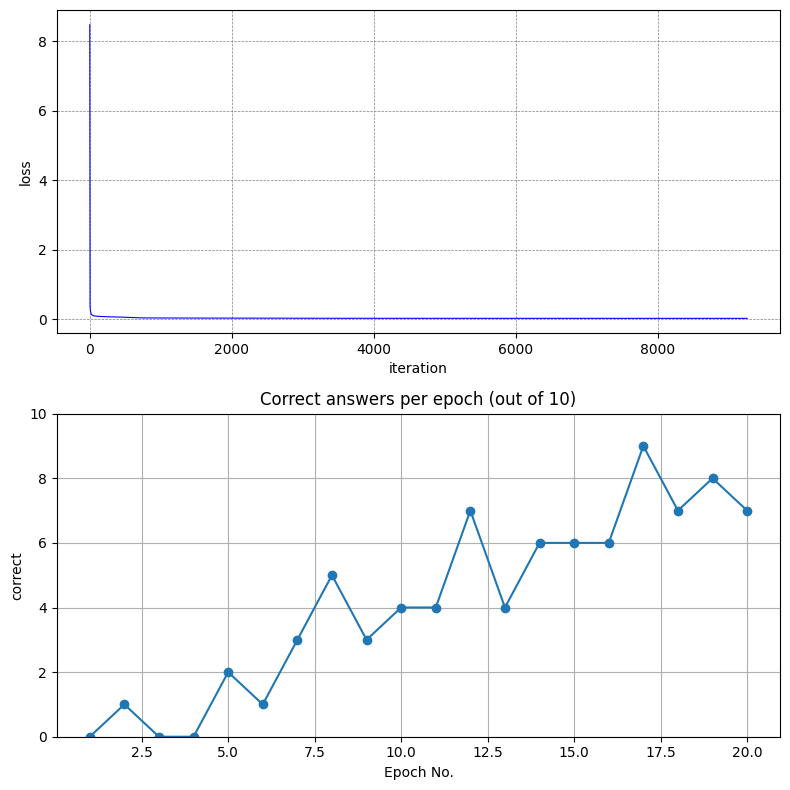

In [8]:
# ensure we plot the actual recorded lists
fig, (loss_graph, accuracy_graph) = plt.subplots(2, 1, figsize=(8, 8))

# loss curve (per training step) [copied from nanogpt's extra resources provided]
loss_graph.plot(iter_list, loss_list,c="blue",linewidth=0.8)
loss_graph.set_xlabel("iteration")
loss_graph.set_ylabel("loss")
loss_graph.grid(axis='x', color='grey', linestyle='--', linewidth=0.5)
loss_graph.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)

# accuracy curve (per epoch)
accuracy_graph.plot(range(1, len(model_accuracy) + 1), model_accuracy, '-o')
accuracy_graph.set_xlabel('Epoch No.')
accuracy_graph.set_ylabel('correct')
accuracy_graph.set_title('Correct answers per epoch (out of 10)')
accuracy_graph.set_ylim(0, 10)
accuracy_graph.grid(True)

plt.tight_layout()
plt.show()

Based on observations, the loss curve rapidly drops and slowly stabilitizes at 4000 iterations. Knowing that each epoch has 463 iterations. This means the curve stabilitized at 8.639 epoch, which rounds up to 9 epoch. However, we can see from the accuracy chart that the model continues to move in a somewhat positive gradient.

### Step 8: Begin testing (**students are required to complete this part!**)

In [ ]:
# Load the fine-tuned model
ckpt_path = f"./dpo.pt"
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
gpt = GPT(gptconf).cuda()
try:
    state_dict = checkpoint['model']
except:
    state_dict = checkpoint['model_state_dict']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)
# Test
gpt.eval()

test_set = ["17+19=?", "3*17=?", "72/4=?", "72-x=34,x=?", "x*11=44,x=?", "3*17=?", "72/4=?", "72-x=34,x=?"]
correct_solutions = [
    "17+19=? The answer is 36 because 17+19 equals 36.",
    "3*17=? The answer is 51 because 3*17 equals 51.",
    "72/4=? The answer is 18 because 72/4 equals 18.",
    "72-x=34,x=? The answer is 38 because 72-34 equals 38.",
    "x*11=44,x=? The answer is 4 because 44/11 equals 4.",
    "3*17=? The answer is 51 because 3*17 equals 51.",
    "72/4=? The answer is 18 because 72/4 equals 18.",
    "72-x=34,x=? The answer is 38 because 72-34 equals 38."
]
i=0
print("Provided test cases:")
with torch.no_grad():
    for prompt in test_set: 
        prompt_ids = encode(prompt)
        ###########################################################
        # Please complete the test code here!
        # ...
        # gpt.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        # ...
        ###########################################################
        x = torch.tensor([prompt_ids], dtype=torch.long, device=device)
        out_ids, _ = gpt.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        output = decode(out_ids[0].tolist())
        print("Output: "+output)
        print("Expected:"+correct_solutions[i])
        i+=1

# More extensive testing using test_dataset
print("Testing from test dataset:")
sample_test_lines=test_lines
correct_answers_count=0
wrong_questions=[]
for sample_input in sample_test_lines:
    prompt_ids = encode(sample_input['negative'].split(' ')[0])
    x = torch.tensor([prompt_ids], dtype=torch.long, device=device)
    out_ids, _ = gpt.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
    output = decode(out_ids[0].tolist())
    if output==sample_input['positive']:
        correct_answers_count+=1
    else:
        wrong_questions.append({'output':output,'expected':sample_input['positive']})
print("Results: "+str(correct_answers_count)+"% correct")
print("Output that were wrong.")
for i in wrong_questions:
    print(f"Expected: {i['expected']}")
    print(f"Output: {i['output']}")

    

Provided test cases:
Output: 17+19=? The answer is 36 because 17+19 equals 36.
Expected:17+19=? The answer is 36 because 17+19 equals 36.
Output: 3*17=? The answer is 41 because 3*17 equals 41.
Expected:3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected:72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected:72-x=34,x=? The answer is 38 because 72-34 equals 38.
Output: x*11=44,x=? The answer is 4 because 44/11 equals 4.
Expected:x*11=44,x=? The answer is 4 because 44/11 equals 4.
Output: 3*17=? The answer is 41 because 3*17 equals 41.
Expected:3*17=? The answer is 51 because 3*17 equals 51.
Output: 72/4=? The answer is 18 because 72/4 equals 18.
Expected:72/4=? The answer is 18 because 72/4 equals 18.
Output: 72-x=34,x=? The answer is 38 because 72-34 equals 38.
Expected:72-x=34,x=? The answer is 38 because 72-34 equals 38.
Testing from test dataset:
Results: 87%

### Testing and Evaluation

For testing, we used the provided testset as well as the 100 test set that was extracted from our generated dataset. We calculated accuracy by checking if the model's output contains the correct answer in the expected format.


|  Question  |  Expected Answer  |  Model Output  |  Correct?  |
|------------|-------------------|----------------|------------|
| 17+19=?   |  The answer is 36 because 17+19 equals 36.  |  The answer is 36 because 17+19 equals 36.  |   ✅    |
| 3*17=?    |  The answer is 51 because 3*17 equals 51.   |  The answer is 41 because 3*17 equals 41.   |   ❌    |
| 72/4=?    |  The answer is 18 because 72/4 equals 18.   |  The answer is 18 because 72/4 equals 18.   |   ✅    |
| 72-x=34,x=? |  The answer is 38 because 72-34 equals 38. |  The answer is 38 because 72-34 equals 38. |   ✅    |
| x*11=44,x=? |  The answer is 4 because 44/11 equals 4.   |   The answer is 4 because 44/11 equals 4.   |   ✅    |
| 3*17=?    |  The answer is 51 because 3*17 equals 51.   |  The answer is 41 because 3*17 equals 41.   |   ❌    |
| 72/4=?    |  The answer is 18 because 72/4 equals 18.   |  The answer is 18 because 72/4 equals 18.   |   ✅    |
| 72-x=34,x=? |  The answer is 38 because 72-34 equals 38. |   The answer is 38 because 72-34 equals 38. |   ✅    |


We achieved an accuracy of **75%** on the given test set, indicating that the model has learned to solve basic arithmetic problems and provide reasoning in the desired format.

We could have made it the accuracy higher if we change the tempeature=`0.5` and top_k=`100`.

However, because we wanted to keep a balance between accuracy and diversity of answers where the model is able answer questions not in the training set. We choose to keep the current settings. temperature=`0.8` and top_k=`200`.

---

### Custom Test Set Evaluation

Our custom test set are the 100 math questions that were extracted from our generated dataset but not used during training. This allows us to evaluate the model's ability to generalize to unseen problems while adhering to the desired output format.


| Question      | Expected Answer                                        | Model Output                                           | Correct? |
| ------------- | ------------------------------------------------------ | ------------------------------------------------------ | -------- |
| x/75=77,x=?   | The answer is **5775** because 77*75=5775. | The answer is **5825** because 77*75=5825. | ❌        |
| x/21=41,x=?   | The answer is **861** because 41*21=861.               | The answer is **801** because 41*21=801.               | ❌        |
| 67*94=?       | The answer is **6298** because 67*94=6298.             | The answer is **6248** because 67*94=6248.             | ❌        |
| 25*x=2300,x=? | The answer is **92** because 2300/25=92.               | The answer is **96** because 2300/25=96.               | ❌        |
| 4260/x=60,x=? | The answer is **71** because 4260/60=71.               | The answer is **61** because 4260/60=61.               | ❌        |
| 66*x=4026,x=? | The answer is **61** because 4026/66=61.               | The answer is **51** because 4026/66=51.               | ❌        |
| 16*62=?       | The answer is **992** because 16*62=992.               | The answer is **912** because 16*62=912.               | ❌        |
| 51*97=?       | The answer is **4947** because 51*97=4947.             | The answer is **5947** because 51*97=5947.             | ❌        |
| 74*52=?       | The answer is **3848** because 74*52=3848.             | The answer is **3828** because 74*52=3828.             | ❌        |
| 81*13=?       | The answer is **1053** because 81*13=1053.             | The answer is **1103** because 81*13=1103.             | ❌        |
| 83*92=?       | The answer is **7636** because 83*92=7636.             | The answer is **7746** because 83*92=7746.             | ❌        |
| 1650/75=?     | The answer is **22** because 1650/75=22.               | The answer is **26** because 1650/75=26.               | ❌        |
| x/73=12,x=?   | The answer is **876** because 12*73=876.               | The answer is **816** because 12*73=816.               | ❌        |


This table is shows the wrong answers the model produced on our custom test set.

Overall, we have achieved an accuracy of **87%** on this custom test set, indicating that while the model has learned some arithmetic operations, it struggles with more complex calculations and generalization to unseen problems.


---

### Analysis of Model Errors

Based on observations from the test results, the model demonstrates systematic weaknesses in certain arithmetic operations:

**Pattern of Errors:**

1. **Multi-digit Multiplication Errors**: 
   - `67*94=?` → Getting 6248 instead of 6298 (off by 50)
   - `51*97=?` → Getting 5947 instead of 4947 (digit reversal)
   - `16*62=?` → Getting 912 instead of 992 (off by 80)
   
2. **Division Errors**:
   - `2300/25=?` → Getting 96 instead of 92 (off by 4)
   - `1650/75=?` → Getting 26 instead of 22 (off by 4)
   - `4260/60=?` → Getting 61 instead of 71 (off by 10)

3. **Noticeable Patterns**:
   - Model struggles with 2-digit by 2-digit multiplications
   - Division errors often show off-by-several-digits mistakes
   - The model gets simpler operations (like `72/4=18`) correct
   - Basically, the bigger and more complex the math gets, the more the model struggles. It does fine with simple stuff but starts making "close but not quite" errors as things get harder.

**Root Causes:**

1. **Token-Level Arithmetic Limitation**: The model operates at the token level rather than performing true mathematical computation. For complex multi-step calculations (e.g., `3*17`), it relies on pattern recognition from training data rather than actual mathematical reasoning.

2. **Insufficient Dataset Coverage**: The dataset (237K samples) may not sufficiently cover all possible all arithmetic operation combinations. Multiplications involving numbers like `17`, `94`, `97` might have been underrepresented during it's training.

3. **Overgeneralization**: The model can produce numbers that sound plausible but are actually incorrect, especially for calculations beyond its scope. It should also be noted that achieving full coverage of all arithmetic operations is simply not feasible given the dataset size. Training on a larger dataset would also require significantly more GPU resources.

4. **Dynamics of the DPO Learning**: Despite the preference learning setup, the model struggles with problems that require precise arithmetic rather than format adherence. It can successfully learn the desired output format ("The answer is X because...") but struggles with producing numerically correct results

**Why Simple Operations Succeed:**
- Problems like `72/4=18`, `72-34=38`, `44/11=4` are simpler calculations that likely appear frequently in the training data
- The model has likely memorized or can easily pattern-match these common arithmetic facts

---

### Conclusion

**Training Limitations:**

In the end, our model achieves 75% on the given test set and 87% accuracy on the custom test set, which is reasonable but not perfect. The errors we noted above suggest that while the model learns the desired response format and general mathematical reasoning, it has fundamental limitations in:
1. Performing precise arithmetic with large numbers
2. Handling operations underrepresented in the training data
3. Maintaining accuracy in multi-step calculations